# Библиотеки

In [160]:
import numpy
import random
import scipy.special # библиотека scipy.special содержит сигмоиду expit()
import pandas
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [161]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# Основной класс нейронной сети

In [162]:
class neuralNetwork:

    def __init__(self, num_nodes_in_layers, learning_rate):
        self.num_nodes_in_layers = num_nodes_in_layers
        self.learning_rate = learning_rate
        self.activation_function = lambda x: scipy.special.expit(x)

        self.weights = []
        for layer in range(len(self.num_nodes_in_layers) - 1):
            cols = self.num_nodes_in_layers[layer + 1]
            rows = self.num_nodes_in_layers[layer]
            weight = numpy.random.rand(cols, rows) - 0.5
            self.weights.append(weight)


    def train(self, inputs, target):
        inputs = numpy.array(inputs, ndmin=2).T
        target = numpy.array(target, ndmin=2).T
        
        # ПРЯМОЕ РАСПРОСТРАНЕНИЕ
        list_outputs = [] # Список всех выходных значений для обратного распространения
        list_outputs.append(inputs)
        output = inputs
        for layer in range(1, len(self.num_nodes_in_layers)):
            input = numpy.dot(self.weights[layer - 1], output)
            output =  self.activation_function(input)
            list_outputs.append(output)

        output_error = target - output # ошибка выходного слоя = (целевое значение - фактическое значение)

        # ОБРАТНОЕ РАСПРОСТРАНЕНИЕ
        # Подсчитать ошибку для каждого слоя
        layer_errors = [] # Список ошибок всех слоев
        layer_errors.append(output_error)
        cur_error = output_error
        for layer in range(len(self.num_nodes_in_layers) - 2, 0, -1): # Перебор в обратном порядке с шагом: -1
            next_error = numpy.dot(self.weights[layer].T, cur_error)
            layer_errors.append(next_error)
            cur_error = next_error
        layer_errors.reverse()

        # Обновить весовые коэффициенты
        for layer in range(len(self.num_nodes_in_layers) - 2, -1, -1): # Перебор в обратном порядке с шагом: -1
            self.weights[layer] += self.learning_rate * numpy.dot((layer_errors[layer] * list_outputs[layer + 1] * (1.0 - list_outputs[layer + 1])), numpy.transpose(list_outputs[layer]))

        return mean_squared_error(target, output)


    def query(self, inputs):
        inputs = numpy.array(inputs, ndmin=2).T
    
        output = inputs
        for layer in range(1, len(self.num_nodes_in_layers)):
            input = numpy.dot(self.weights[layer - 1], output)
            output =  self.activation_function(input)
        
        return output

# Загрузка тренировочных данных

In [163]:
csv_file = pandas.read_csv("/content/drive/MyDrive/approx_func/train_data.csv", header=None)
# print(csv_file)

scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
data_list = scaler.fit_transform(csv_file)
# print(data_list)

scaler_targets = preprocessing.MinMaxScaler(feature_range=(0, 1))
targets_data = scaler_targets.fit_transform(csv_file.iloc[:, [3]])
# print(targets_data)

# Тренировка нейронной сети

In [164]:
NUM_NODES_IN_LAYERS = [3, 100, 100, 1]
LEARNING_RATE = 0.1
NUM_EPOCHS = 3000

nn = neuralNetwork(NUM_NODES_IN_LAYERS, LEARNING_RATE)

In [165]:
data_list.tolist()
mse_list = []

for epoch in range(NUM_EPOCHS):
    mse = 0
    numpy.random.shuffle(data_list)
    for record in data_list:
        inputs = numpy.array(record[:3])
        target = record[3]
        mse += nn.train(inputs, target)
    mse_list.append(mse)
# print(mse_list)

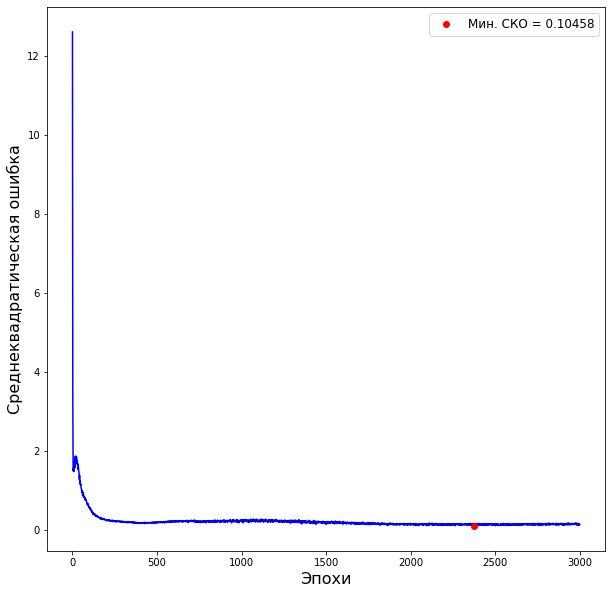

In [166]:
plt.figure(figsize=(10, 10))
plt.plot(range(NUM_EPOCHS), mse_list, color="Blue")
plt.plot(numpy.argmin(mse_list), min(mse_list), 'ro', label='Мин. СКО = {0}'.format(round(min(mse_list), 5)))
# plt.suptitle('Зависимость СКО от количества эпох', fontsize = 15)
plt.xlabel("Эпохи", fontsize = 16)
plt.ylabel("Среднеквадратическая ошибка", fontsize = 16)
plt.legend(fontsize = 12)
plt.show()

# Тестирование нейронной сети

In [167]:
csv_file = pandas.read_csv("/content/drive/MyDrive/approx_func/test_data.csv", header=None)
# print(csv_file)

scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
data_list = scaler.fit_transform(csv_file)
# print(data_list)

In [168]:
output_list = []
for input in data_list:
    output = nn.query(input[:3])
    output = scaler_targets.inverse_transform(output)
    output_list.append(round(output.item()))
print(output_list)

[3842, 5871, 4254, -1289, 275, 12, -438, -288, 3409, 776, -523, 74, 12, -825, 4885, -1302, 6972, 583, -201, 342, 45, 739, 926, -1255, 18, 6963, -162, -591, 1290, 416, 666, 3823, -65, -560, 7259, 3978, -1212, 1474, 2455, 6243]
